In [23]:
import torch
import time
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.utils.prune as prune

from ptflops import get_model_complexity_info
from fvcore.nn import FlopCountAnalysis, parameter_count

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Test data was only thrown into tensor and normalized as this is not altering the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
#Load Dataset (Example: CIFAR-10)
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

if device == "cuda":
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")



#Define the Model Architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=0)  # Conv Layer (3 input channels for RGB images)
        self.bn1 = nn.BatchNorm2d(8)  # Batch Normalization
        self.pool = nn.MaxPool2d(2, 2)  # Max Pooling
   

        self.fc1 = nn.Linear(1800, 512)  # Fully Connected Layer 1
        self.fc2 = nn.Linear(512, 256)  # Fully Connected Layer 2
        self.fc3 = nn.Linear(256, 128)  # Fully Connected Layer 2
        self.fc4 = nn.Linear(128, 10)  # Output layer (10 classes for CIFAR-10)


    def forward(self, x):
        # CNN Layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        # print("X_conv size:",x.shape)
        # Flatten for Fully Connected Layers
        # x = x.view(-1, 1800)

        x = x.view(x.size(0), -1)

        # print("X_flat:",x.shape)
        # Fully Connected Layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
    
model = SimpleCNN().to(device)
print(model)

Using cuda device
Number of GPUs: 4
GPU 0: Tesla K80
GPU 1: Tesla K80
GPU 2: Tesla K80
GPU 3: Tesla K80
SimpleCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
learning_rate = 0.8

In [6]:
criterion = nn.CrossEntropyLoss()

In [103]:
#Train the model (without optimizer, using regular gradient descent)
def train(model, train_loader, criterion, learning_rate, num_epochs=5):
    model.train()
    train_acc = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        print(epoch)
        for inputs, labels in train_loader:
            # Move data to GPU if available
            inputs, labels = inputs.cuda(), labels.cuda() if torch.cuda.is_available() else (inputs, labels)
            # print("Inputs size:",inputs.shape)
            # print("Labels shape:",labels.shape)
            # Zero the gradients manually
            model.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            # print(outputs.shape)

            # Compute loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Manually update weights (regular gradient descent)
            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad
            
            # Track the loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")
    train_acc.append(100*correct/total)
    return (train_acc)

In [89]:
#Evaluate the model on the test dataset
def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda() if torch.cuda.is_available() else (inputs, labels)
            
            # Forward pass
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Test Accuracy: {100*correct/total:.2f}%")
    return 100*correct/total

In [90]:
#Move the model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
#Train and Evaluate the Model
start_time = time.time()
train(model, train_loader, criterion, learning_rate, num_epochs=40)
total_time = time.time() - start_time
print(f"Total Time: {total_time:.2f} seconds")

start_time_eval = time.time()
evaluate(model, test_loader)
total_time_eval = time.time() - start_time_eval
print(f"Total Time: {total_time_eval:.2f} seconds")

0
Epoch 1/40, Loss: 1.7868, Accuracy: 36.02%
1
Epoch 2/40, Loss: 1.6168, Accuracy: 41.93%
2
Epoch 3/40, Loss: 1.5361, Accuracy: 45.17%
3
Epoch 4/40, Loss: 1.4895, Accuracy: 47.24%
4
Epoch 5/40, Loss: 1.4026, Accuracy: 50.61%
5
Epoch 6/40, Loss: 1.3455, Accuracy: 52.59%
6
Epoch 7/40, Loss: 1.2927, Accuracy: 54.22%
7
Epoch 8/40, Loss: 1.2610, Accuracy: 55.69%
8
Epoch 9/40, Loss: 1.2193, Accuracy: 57.17%
9
Epoch 10/40, Loss: 1.1758, Accuracy: 58.73%
10
Epoch 11/40, Loss: 1.1226, Accuracy: 60.38%
11
Epoch 12/40, Loss: 1.0962, Accuracy: 61.53%
12
Epoch 13/40, Loss: 1.0799, Accuracy: 61.90%
13
Epoch 14/40, Loss: 1.0311, Accuracy: 63.69%
14
Epoch 15/40, Loss: 1.0160, Accuracy: 64.45%
15
Epoch 16/40, Loss: 0.9913, Accuracy: 64.95%
16
Epoch 17/40, Loss: 0.9684, Accuracy: 66.02%
17
Epoch 18/40, Loss: 0.9469, Accuracy: 66.59%
18
Epoch 19/40, Loss: 0.9180, Accuracy: 67.72%
19
Epoch 20/40, Loss: 0.8963, Accuracy: 68.43%
20
Epoch 21/40, Loss: 0.8835, Accuracy: 69.02%
21
Epoch 22/40, Loss: 0.8619, Ac

In [12]:
start_time_eval = time.time()
evaluate(model, test_loader)
total_time_eval = time.time() - start_time_eval
print(f"Total Time: {total_time_eval:.2f} seconds")

Test Accuracy: 64.48%
Total Time: 2.84 seconds


In [ ]:
#Save model
torch.save(model.state_dict(), "project2_before_pruning.pth")
print("Saved PyTorch Model State to project2_after_pruning.pth")

Saved PyTorch Model State to project2_after_pruning.pth


In [11]:
#Load the model
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("project2_before_pruning.pth"))

<All keys matched successfully>

In [13]:
def check_structured_sparsity(model):
    # Check conv1 channel sparsity
    conv_channels = model.conv1.weight.size(0)
    channel_norms = torch.norm(model.conv1.weight.view(conv_channels, -1), p=2, dim=1)
    zero_channels = torch.sum(channel_norms == 0).item()
    print(f"Conv1: {zero_channels}/{conv_channels} channels pruned ({100*zero_channels/conv_channels:.2f}%)")
    
    # Check fc1 neuron sparsity
    fc1_neurons = model.fc1.weight.size(0)
    neuron_norms = torch.norm(model.fc1.weight, p=2, dim=1)
    zero_neurons = torch.sum(neuron_norms == 0).item()
    print(f"FC1: {zero_neurons}/{fc1_neurons} neurons pruned ({100*zero_neurons/fc1_neurons:.2f}%)")
    
    # Check fc2 neuron sparsity
    fc2_neurons = model.fc2.weight.size(0)
    neuron_norms = torch.norm(model.fc2.weight, p=2, dim=1)
    zero_neurons = torch.sum(neuron_norms == 0).item()
    print(f"FC2: {zero_neurons}/{fc2_neurons} neurons pruned ({100*zero_neurons/fc2_neurons:.2f}%)")

     # Check fc2 neuron sparsity
    fc3_neurons = model.fc3.weight.size(0)
    neuron_norms = torch.norm(model.fc3.weight, p=2, dim=1)
    zero_neurons = torch.sum(neuron_norms == 0).item()
    print(f"FC3: {zero_neurons}/{fc3_neurons} neurons pruned ({100*zero_neurons/fc3_neurons:.2f}%)")

# Check sparsity after pruning
check_structured_sparsity(model)

Conv1: 0/8 channels pruned (0.00%)
FC1: 0/512 neurons pruned (0.00%)
FC2: 0/256 neurons pruned (0.00%)
FC3: 0/128 neurons pruned (0.00%)


In [104]:
results_eval = []

for pruning_amount in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,.95,.99]:   

    model = SimpleCNN().to(device)
    model.load_state_dict(torch.load("project2_before_pruning.pth"))

    
    prune.ln_structured(model.conv1, name="weight", amount=pruning_amount, n=2, dim=0)
    prune.ln_structured(model.fc1, name="weight", amount=pruning_amount, n=2, dim=0)
    prune.ln_structured(model.fc2, name="weight", amount=pruning_amount, n=2, dim=0)
    prune.ln_structured(model.fc3, name="weight", amount=pruning_amount, n=2, dim=0)
    
    prune.remove(model.conv1, 'weight')
    prune.remove(model.fc1, 'weight')
    prune.remove(model.fc2, 'weight')
    prune.remove(model.fc3, 'weight')

    nonzero_params = sum(p.nonzero().size(0) for p in model.parameters())

    print(f"Non-zero parameters after pruning: {nonzero_params}")

    before_train_test_acc = evaluate(model, test_loader)

    train_acc = train(model, train_loader, criterion, learning_rate = 1e-4, num_epochs=10)

    test_acc = evaluate(model, test_loader)

    check_structured_sparsity(model)

    # Save the pruned model with a unique file name
    model_file_name = f"project2_after_pruning_{pruning_amount}.pth"
    torch.save(model.state_dict(), model_file_name)
    print(f"Saved PyTorch Model State to {model_file_name}")

    results_eval.append((nonzero_params, test_acc, before_train_test_acc, train_acc))


Non-zero parameters after pruning: 1087866
Test Accuracy: 64.48%
0
Epoch 1/10, Loss: 0.6181, Accuracy: 77.93%
1
Epoch 2/10, Loss: 0.6126, Accuracy: 78.30%
2
Epoch 3/10, Loss: 0.6066, Accuracy: 78.58%
3
Epoch 4/10, Loss: 0.6037, Accuracy: 78.68%
4
Epoch 5/10, Loss: 0.6018, Accuracy: 78.43%
5
Epoch 6/10, Loss: 0.5982, Accuracy: 78.69%
6
Epoch 7/10, Loss: 0.5912, Accuracy: 78.83%
7
Epoch 8/10, Loss: 0.5925, Accuracy: 79.03%
8
Epoch 9/10, Loss: 0.5882, Accuracy: 79.22%
9
Epoch 10/10, Loss: 0.5808, Accuracy: 79.31%
Test Accuracy: 65.11%
Conv1: 0/8 channels pruned (0.00%)
FC1: 0/512 neurons pruned (0.00%)
FC2: 0/256 neurons pruned (0.00%)
FC3: 0/128 neurons pruned (0.00%)
Saved PyTorch Model State to project2_after_pruning_0.pth
Non-zero parameters after pruning: 979399
Test Accuracy: 61.14%
0
Epoch 1/10, Loss: 0.8637, Accuracy: 70.81%
1
Epoch 2/10, Loss: 0.8489, Accuracy: 71.14%
2
Epoch 3/10, Loss: 0.8431, Accuracy: 71.32%
3
Epoch 4/10, Loss: 0.8359, Accuracy: 71.43%
4
Epoch 5/10, Loss: 0.8

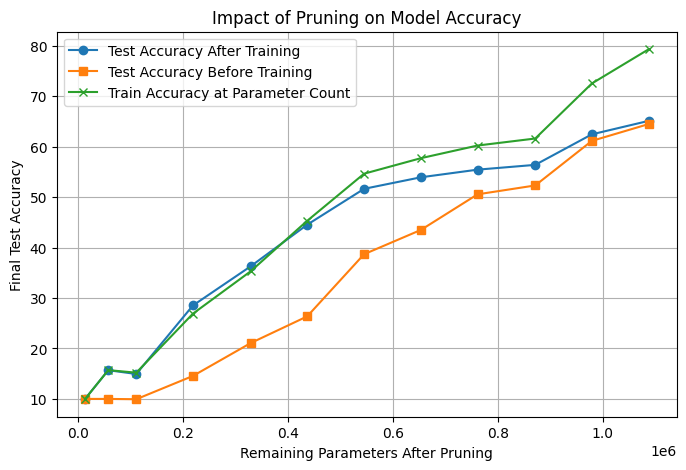

In [105]:
x = [r[0] for r in results_eval]  # remaining parameters
y_before = [r[2] for r in results_eval]  # test before train accuracy
y_after = [r[1] for r in results_eval]  # final test accuracy
train_accuracy = [r[3] for r in results_eval]  # test accuracy after training

plt.figure(figsize=(8, 5))
plt.plot(x, y_after, marker='o', label="Test Accuracy After Training")
plt.plot(x, y_before, marker='s', label="Test Accuracy Before Training")
plt.plot(x, train_accuracy, marker='x', label="Train Accuracy at Parameter Count")
plt.xlabel("Remaining Parameters After Pruning")
plt.ylabel("Final Test Accuracy")
plt.title("Impact of Pruning on Model Accuracy")
plt.grid(True)
plt.legend()
plt.show()


In [106]:
results_eval = []


for pruning_amount in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,.95,.99]: 
    
    model = SimpleCNN().to(device)
    model.load_state_dict(torch.load("project2_before_pruning.pth"))

   
    prune.l1_unstructured(model.conv1, name="weight", amount=pruning_amount)
    prune.l1_unstructured(model.fc1, name="weight", amount=pruning_amount)
    prune.l1_unstructured(model.fc2, name="weight", amount=pruning_amount)
    prune.l1_unstructured(model.fc3, name="weight", amount=pruning_amount)


    prune.remove(model.conv1, 'weight')
    prune.remove(model.fc1, 'weight')
    prune.remove(model.fc2, 'weight')
    prune.remove(model.fc3, 'weight')

    nonzero_params = sum(p.nonzero().size(0) for p in model.parameters())

    print("Remaining parameters after pruning:", nonzero_params)

    before_train_test_acc = evaluate(model, test_loader)

    train_acc = train(model, train_loader, criterion, learning_rate = 1e-4, num_epochs=10)

    test_acc = evaluate(model, test_loader)
   
    # Save the pruned model with a unique file name
    model_file_name = f"project2_after_pruning_unstruct_{pruning_amount}.pth"
    torch.save(model.state_dict(), model_file_name)
    print(f"Saved PyTorch Model State to {model_file_name}")
    
    results_eval.append((nonzero_params, test_acc, before_train_test_acc, train_acc))


Remaining parameters after pruning: 1087866
Test Accuracy: 64.48%
0
Epoch 1/10, Loss: 0.6156, Accuracy: 78.20%
1
Epoch 2/10, Loss: 0.6119, Accuracy: 78.42%
2
Epoch 3/10, Loss: 0.6099, Accuracy: 78.57%
3
Epoch 4/10, Loss: 0.6067, Accuracy: 78.58%
4
Epoch 5/10, Loss: 0.5945, Accuracy: 79.02%
5
Epoch 6/10, Loss: 0.5997, Accuracy: 78.63%
6
Epoch 7/10, Loss: 0.5957, Accuracy: 79.02%
7
Epoch 8/10, Loss: 0.5887, Accuracy: 79.06%
8
Epoch 9/10, Loss: 0.5907, Accuracy: 79.05%
9
Epoch 10/10, Loss: 0.5835, Accuracy: 79.42%
Test Accuracy: 65.17%
Saved PyTorch Model State to project2_after_pruning_unstruct_0.pth
Remaining parameters after pruning: 979300
Test Accuracy: 64.34%
0
Epoch 1/10, Loss: 0.6169, Accuracy: 78.17%
1
Epoch 2/10, Loss: 0.6094, Accuracy: 78.58%
2
Epoch 3/10, Loss: 0.6060, Accuracy: 78.53%
3
Epoch 4/10, Loss: 0.5991, Accuracy: 78.69%
4
Epoch 5/10, Loss: 0.5985, Accuracy: 78.79%
5
Epoch 6/10, Loss: 0.5960, Accuracy: 78.83%
6
Epoch 7/10, Loss: 0.5955, Accuracy: 78.94%
7
Epoch 8/10, 

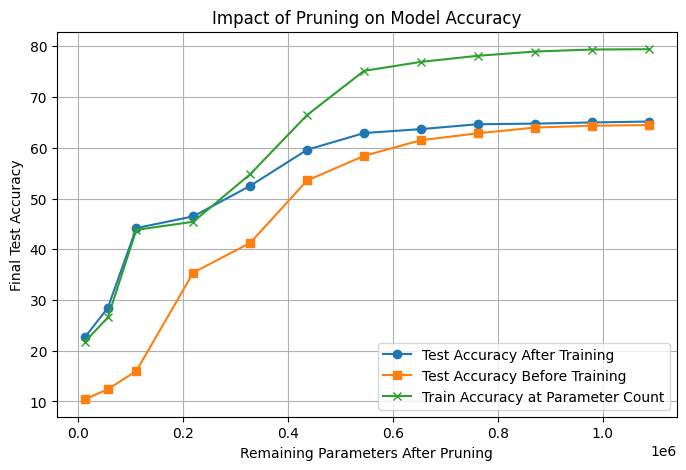

In [107]:
x = [r[0] for r in results_eval]  # remaining parameters
y_before = [r[2] for r in results_eval]  # test before train accuracy
y_after = [r[1] for r in results_eval]  # final test accuracy
train_accuracy = [r[3] for r in results_eval]  # test accuracy after training

plt.figure(figsize=(8, 5))
plt.plot(x, y_after, marker='o', label="Test Accuracy After Training")
plt.plot(x, y_before, marker='s', label="Test Accuracy Before Training")
plt.plot(x, train_accuracy, marker='x', label="Train Accuracy at Parameter Count")
plt.xlabel("Remaining Parameters After Pruning")
plt.ylabel("Final Test Accuracy")
plt.title("Impact of Pruning on Model Accuracy")
plt.grid(True)
plt.legend()
plt.show()


In [20]:
#Load the model
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("project2_before_pruning.pth"))

start_time_eval = time.time()
evaluate(model, test_loader)
total_time_eval = time.time() - start_time_eval
print(f"Total Time: {total_time_eval:.2f} seconds")

Test Accuracy: 10.00%


10.0